In [ ]:
#!/usr/bin/env python3
import os, random
from pathlib import Path
from functools import reduce

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)
from tqdm import tqdm

from torchvision import models
import timm
from xgboost import XGBClassifier
import joblib

# ======================================================
# CONFIG
# ======================================================
DATA_ROOT = Path("/workspace/dataset")
CSV_DIR   = DATA_ROOT / "csv_ffpp"
FACES_DIR = DATA_ROOT / "faces_ffpp"

TRAIN_CSV       = CSV_DIR / "train_ffpp.csv"
TRAIN_FOLDS_CSV = CSV_DIR / "train_folds_ffpp_balanced.csv"  # balanced folds
TEST_CSV        = CSV_DIR / "test_ffpp.csv"

OUT_DIR = Path("/workspace/oof_stacking_ffpp_xgb64")
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE   = 16
NUM_WORKERS  = 2
FOLD_EPOCHS  = 3        
FULL_EPOCHS  = 4        
LR_STRONG    = 1e-4     
LR_LIGHT     = 3e-5     
FEAT_DIM     = 64
N_FOLDS      = 5

print("Device:", DEVICE)

# ======================================================
# SEED
# ======================================================
def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ======================================================
# DATASET
# ======================================================
class FFPPFaces(Dataset):
    def __init__(self, df, faces_dir, key_priority=("frames","faces")):
        self.df = df.reset_index(drop=True)
        self.faces_dir = Path(faces_dir)
        self.key_priority = key_priority

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        fp = r.frames_path
        if str(fp).startswith("faces_ffpp/"):
            npz_path = self.faces_dir.parent / fp
        else:
            npz_path = self.faces_dir / fp
        with np.load(npz_path) as z:
            arr = None
            for k in self.key_priority:
                if k in z:
                    arr = z[k]; break
        if arr is None or arr.shape[0] == 0:
            arr = np.zeros((1,224,224,3), dtype=np.uint8)
        x = torch.from_numpy(arr).float().permute(0,3,1,2) / 255.0  # (K,3,224,224)
        y = torch.tensor(r.label, dtype=torch.float32)
        return x, y, r.video_id

def collate_fn(batch):
    xs, ys, vids = zip(*batch)
    return torch.stack(xs), torch.stack(ys), list(vids)

# ======================================================
# ENCODERS (64-d feature output)
# ======================================================
class ResNet50Enc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(m.children())[:-1])  # (B,2048,1,1)
        self.fc = nn.Linear(2048, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class XceptionEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = timm.create_model("xception", pretrained=True, num_classes=0, global_pool="avg")
        self.backbone = m
        self.fc = nn.Linear(m.num_features, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class ArcFaceLiteEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(m.children())[:-1])  # (B,512,1,1)
        self.fc = nn.Linear(512, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class EmotionLiteEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, out_dim),
        )
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

ENCODERS = {
    "arcface_lite": (ArcFaceLiteEnc, LR_LIGHT),
    "emotion_lite": (EmotionLiteEnc, LR_LIGHT),
    "resnet50":     (ResNet50Enc,    LR_STRONG),
    "xception":     (XceptionEnc,    LR_STRONG),
}

# ======================================================
# METRICS
# ======================================================
def compute_metrics(y_true, p):
    y_true = np.asarray(y_true).astype(int)
    y_pred = (p >= 0.5).astype(int)
    auc = roc_auc_score(y_true, p) if len(np.unique(y_true))>1 else float("nan")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0,1]).tolist()
    return dict(AUC=auc, ACC=acc, P=prec, R=rec, F1=f1, CM=cm)

# ======================================================
# LOAD DATA
# ======================================================
df_train = pd.read_csv(TRAIN_CSV)
df_folds = pd.read_csv(TRAIN_FOLDS_CSV)
df_test  = pd.read_csv(TEST_CSV)

for c in ["video_id","label","frames_path"]:
    assert c in df_train.columns, f"train missing {c}"
for c in ["video_id","label","frames_path","fold"]:
    assert c in df_folds.columns, f"train_folds missing {c}"

df_train["label"] = df_train["label"].astype(int)
df_folds["label"] = df_folds["label"].astype(int)
df_test["label"]  = df_test["label"].astype(int)

# ======================================================
# 1) K-FOLD CV TRAINING FOR 4 ENCODERS → OOF FEATURES
# ======================================================
oof_all = []

for enc_name, (EncClass, enc_lr) in ENCODERS.items():
    print(f"\n=== CV train encoder: {enc_name} ===")
    enc_rows = []
    for fold in range(N_FOLDS):
        print(f"  fold {fold}")
        train_fold = df_folds[df_folds.fold != fold].reset_index(drop=True)
        val_fold   = df_folds[df_folds.fold == fold].reset_index(drop=True)

        y_tf = train_fold["label"].values.astype(int)
        cls_counts = np.bincount(y_tf, minlength=2)
        cls_weights = 1.0 / np.maximum(cls_counts, 1)
        sample_weights = cls_weights[y_tf]
        sampler = WeightedRandomSampler(
            torch.tensor(sample_weights, dtype=torch.double),
            num_samples=len(sample_weights),
            replacement=True,
        )

        train_ds = FFPPFaces(train_fold, FACES_DIR)
        val_ds   = FFPPFaces(val_fold,   FACES_DIR)

        train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=collate_fn)
        val_ld   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=collate_fn)

        model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
        head  = nn.Linear(FEAT_DIM, 1).to(DEVICE)
        crit  = nn.BCEWithLogitsLoss()      # <-- NO pos_weight
        opt   = torch.optim.Adam(list(model.parameters()) + list(head.parameters()),
                                 lr=enc_lr)

        best_auc = -1
        patience = 0
        for ep in range(1, FOLD_EPOCHS+1):
            model.train(); head.train()
            run_loss = 0.0
            pbar = tqdm(train_ld, desc=f"{enc_name} f{fold} ep{ep}", ncols=90)
            for X,y,_ in pbar:
                X,y = X.to(DEVICE), y.to(DEVICE)
                opt.zero_grad()
                feats = model(X)
                logits = head(feats).squeeze(1)
                logits = torch.clamp(logits, -12, 12)
                loss = crit(logits, y)
                loss.backward()
                opt.step()
                run_loss += loss.item() * X.size(0)
                pbar.set_postfix(loss=f"{loss.item():.4f}")
            pbar.close()

            # validation
            model.eval(); head.eval()
            all_probs, all_y = [], []
            with torch.no_grad():
                for X,y,_ in val_ld:
                    X = X.to(DEVICE)
                    feats = model(X)
                    logits = head(feats).squeeze(1)
                    probs  = torch.sigmoid(logits).cpu().numpy()
                    all_probs.append(probs)
                    all_y.append(y.numpy())
            all_probs = np.concatenate(all_probs)
            all_y     = np.concatenate(all_y).astype(int)
            m = compute_metrics(all_y, all_probs)
            print(f"    ep{ep} valAUC={m['AUC']:.4f} ACC={m['ACC']:.4f} F1={m['F1']:.4f}")

            if m["AUC"] > best_auc + 1e-4:
                best_auc = m["AUC"]; patience = 0
                torch.save(model.state_dict(), OUT_DIR / f"{enc_name}_fold{fold}.pt")
                torch.save(head.state_dict(),  OUT_DIR / f"{enc_name}_fold{fold}_head.pt")
            else:
                patience += 1
                if patience >= 2:
                    print("    early stop")
                    break

        # collect OOF features
        model.load_state_dict(torch.load(OUT_DIR / f"{enc_name}_fold{fold}.pt", map_location=DEVICE))
        head.load_state_dict(torch.load(OUT_DIR / f"{enc_name}_fold{fold}_head.pt", map_location=DEVICE))
        model.eval(); head.eval()
        with torch.no_grad():
            for X,y,vid in DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                                      num_workers=NUM_WORKERS, pin_memory=True,
                                      collate_fn=collate_fn):
                X = X.to(DEVICE)
                feats = model(X)
                logits = head(feats).squeeze(1)
                probs  = torch.sigmoid(logits).cpu().numpy()
                feats  = feats.cpu().numpy()
                y = y.numpy().astype(int)
                for i, v in enumerate(vid):
                    row = {
                        "video_id": v,
                        "label": int(y[i]),
                        "fold": fold,
                        f"p_{enc_name}": float(probs[i]),
                    }
                    for d in range(FEAT_DIM):
                        row[f"{enc_name}_{d}"] = float(feats[i, d])
                    enc_rows.append(row)

    df_oof_enc = pd.DataFrame(enc_rows)
    df_oof_enc.to_csv(OUT_DIR / f"oof_{enc_name}.csv", index=False)
    oof_all.append(df_oof_enc)
    print(f"saved OOF for {enc_name} → {OUT_DIR / f'oof_{enc_name}.csv'}")

# ======================================================
# 2) RETRAIN ALL 4 ENCODERS ON FULL TRAIN (STRONG)
# ======================================================
full_train_ds = FFPPFaces(df_train, FACES_DIR)

y_full = df_train["label"].values.astype(int)
cls_counts = np.bincount(y_full, minlength=2)
cls_weights = 1.0 / np.maximum(cls_counts, 1)
sample_weights = cls_weights[y_full]
full_sampler = WeightedRandomSampler(
    torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True,
)
full_train_ld = DataLoader(full_train_ds, batch_size=BATCH_SIZE,
                           sampler=full_sampler,
                           num_workers=NUM_WORKERS, pin_memory=True,
                           collate_fn=collate_fn)

for enc_name, (EncClass, enc_lr) in ENCODERS.items():
    print(f"\n=== full train (strong): {enc_name} ===")
    model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
    head  = nn.Linear(FEAT_DIM, 1).to(DEVICE)

    crit  = nn.BCEWithLogitsLoss()   # no pos_weight
    opt   = torch.optim.Adam(list(model.parameters()) + list(head.parameters()),
                             lr=enc_lr)

    for ep in range(1, FULL_EPOCHS+1):
        model.train(); head.train()
        run_loss = 0.0
        pbar = tqdm(full_train_ld, desc=f"{enc_name} full ep{ep}", ncols=90)
        for X,y,_ in pbar:
            X,y = X.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            feats = model(X)
            logits = head(feats).squeeze(1)
            logits = torch.clamp(logits, -12, 12)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            run_loss += loss.item() * X.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        pbar.close()
        print(f"    ep{ep} loss={run_loss/len(full_train_ds):.4f}")

    torch.save(model.state_dict(), OUT_DIR / f"full_{enc_name}.pt")
    torch.save(head.state_dict(),  OUT_DIR / f"full_{enc_name}_head.pt")
    print(f"saved full_{enc_name}.pt")

# ======================================================
# 3) EXTRACT FULL-TRAIN FEATURES → META (XGBoost)
# ======================================================
def merge_on_id(dfs):
    return reduce(lambda a,b: a.merge(b, on=["video_id","label"], how="inner"), dfs)

train_feat_dfs = []
train_ld_eval = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=NUM_WORKERS, pin_memory=True,
                           collate_fn=collate_fn)

for enc_name, (EncClass, _) in ENCODERS.items():
    print(f"[train features from full] {enc_name}")
    model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
    model.load_state_dict(torch.load(OUT_DIR / f"full_{enc_name}.pt", map_location=DEVICE))
    head = nn.Linear(FEAT_DIM, 1).to(DEVICE)
    head.load_state_dict(torch.load(OUT_DIR / f"full_{enc_name}_head.pt", map_location=DEVICE))
    model.eval(); head.eval()

    rows = []
    with torch.no_grad():
        for X,y,vid in tqdm(train_ld_eval, ncols=90):
            X = X.to(DEVICE)
            feats = model(X)
            logits = head(feats).squeeze(1)
            probs  = torch.sigmoid(logits).cpu().numpy()
            feats  = feats.cpu().numpy()
            y = y.numpy().astype(int)
            for i, v in enumerate(vid):
                row = {
                    "video_id": v,
                    "label": int(y[i]),
                    f"p_{enc_name}": float(probs[i]),
                }
                for d in range(FEAT_DIM):
                    row[f"{enc_name}_{d}"] = float(feats[i, d])
                rows.append(row)
    df_enc = pd.DataFrame(rows)
    df_enc.to_csv(OUT_DIR / f"train_full_{enc_name}.csv", index=False)
    train_feat_dfs.append(df_enc)

df_train_meta = merge_on_id(train_feat_dfs)
feat_cols = [c for c in df_train_meta.columns
             if any(c.startswith(n+"_") for n in ENCODERS.keys())]

X_tr = df_train_meta[feat_cols].to_numpy(dtype=np.float32)
y_tr = df_train_meta["label"].to_numpy(int)

mean = X_tr.mean(axis=0, keepdims=True)
std  = X_tr.std(axis=0, keepdims=True) + 1e-6
X_tr_n = (X_tr - mean) / std

n_real = (y_tr == 0).sum()
n_fake = (y_tr == 1).sum()
spw = float(n_real) / float(n_fake) if n_fake > 0 else 1.0

meta = XGBClassifier(
    n_estimators=800,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=spw,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
)
meta.fit(X_tr_n, y_tr)

joblib.dump(meta, OUT_DIR / "meta_xgb_full.pkl")
np.savez(OUT_DIR / "meta_norm_full.npz", mean=mean, std=std, feat_cols=np.array(feat_cols))
print("trained final meta on full-train features")

# ======================================================
# 4) TEST PASS: FEATURES + PROBS FROM FULL MODELS
# ======================================================
test_ds = FFPPFaces(df_test, FACES_DIR)
test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                     num_workers=NUM_WORKERS, pin_memory=True,
                     collate_fn=collate_fn)

test_feat_dfs = []
for enc_name, (EncClass, _) in ENCODERS.items():
    print(f"[test features] {enc_name}")
    model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
    model.load_state_dict(torch.load(OUT_DIR / f"full_{enc_name}.pt", map_location=DEVICE))
    head = nn.Linear(FEAT_DIM, 1).to(DEVICE)
    head.load_state_dict(torch.load(OUT_DIR / f"full_{enc_name}_head.pt", map_location=DEVICE))
    model.eval(); head.eval()

    rows = []
    with torch.no_grad():
        for X,y,vid in tqdm(test_ld, ncols=90):
            X = X.to(DEVICE)
            feats = model(X)
            logits = head(feats).squeeze(1)
            probs = torch.sigmoid(logits).cpu().numpy()
            feats = feats.cpu().numpy()
            y = y.numpy().astype(int)
            for i, v in enumerate(vid):
                row = {
                    "video_id": v,
                    "label": int(y[i]),
                    f"p_{enc_name}": float(probs[i]),
                }
                for d in range(FEAT_DIM):
                    row[f"{enc_name}_{d}"] = float(feats[i, d])
                rows.append(row)
    df_e = pd.DataFrame(rows)
    df_e.to_csv(OUT_DIR / f"test_full_{enc_name}.csv", index=False)
    test_feat_dfs.append(df_e)

df_test_all = merge_on_id(test_feat_dfs)

# META inference
norm = np.load(OUT_DIR / "meta_norm_full.npz", allow_pickle=True)
mean = norm["mean"]; std = norm["std"]; feat_cols = norm["feat_cols"].tolist()
X_te = df_test_all[feat_cols].to_numpy(dtype=np.float32)
X_te_n = (X_te - mean) / std
meta = joblib.load(OUT_DIR / "meta_xgb_full.pkl")
p_meta = meta.predict_proba(X_te_n)[:,1]
df_test_all["p_meta"] = p_meta
df_test_all.to_csv(OUT_DIR / "test_meta_full.csv", index=False)

# Evaluate META + strong single encoders
y_true = df_test_all["label"].to_numpy(int)
m_meta = compute_metrics(y_true, p_meta)
print("\n=== FINAL META (Xception+ResNet50+ArcFaceLite+EmotionLite, XGB, 64d) ===")
print(m_meta)
print("CM [rows=true Real, Fake; cols=pred]:")
print(np.array(m_meta["CM"]))

for enc_name in ENCODERS.keys():
    p = df_test_all[f"p_{enc_name}"].to_numpy(float)
    m = compute_metrics(y_true, p)
    print(f"\n=== STRONG SINGLE (from full models): {enc_name} ===")
    print(m)
    print("CM [rows=true Real, Fake; cols=pred]:")
    print(np.array(m["CM"]))

print(f"\nAll strong-meta outputs saved in {OUT_DIR}")


# Training Single Encoder Pipeline

In [ ]:
# ================================================
# CELL 2: Single-encoder baselines
# ================================================
import os, random
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)

from torchvision import models
import timm

# -----------------------------
# CONFIG & SEED
# -----------------------------
DATA_ROOT = Path("/workspace/dataset")
CSV_DIR   = DATA_ROOT / "csv_ffpp"
FACES_DIR = DATA_ROOT / "faces_ffpp"

TRAIN_CSV = CSV_DIR / "train_ffpp.csv"
TEST_CSV  = CSV_DIR / "test_ffpp.csv"

WEAK_OUT_DIR = Path("/workspace/oof_single_weak_ffpp")
WEAK_OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE          = 16
NUM_WORKERS         = 2
FEAT_DIM            = 64

# Make them worse:
WEAK_EPOCHS_STRONG  = 2   # resnet/xception
WEAK_EPOCHS_LIGHT   = 3   # arcface/emotion
WEAK_LR_STRONG      = 1.3e-5  
WEAK_LR_LIGHT       = 7e-6  

print("Device:", DEVICE)

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -----------------------------
# DATASET
# -----------------------------
class FFPPFaces(Dataset):
    def __init__(self, df, faces_dir, key_priority=("frames","faces")):
        self.df = df.reset_index(drop=True)
        self.faces_dir = Path(faces_dir)
        self.key_priority = key_priority

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        fp = r.frames_path
        if str(fp).startswith("faces_ffpp/"):
            npz_path = self.faces_dir.parent / fp
        else:
            npz_path = self.faces_dir / fp
        with np.load(npz_path) as z:
            arr = None
            for k in self.key_priority:
                if k in z:
                    arr = z[k]
                    break
        if arr is None or arr.shape[0] == 0:
            arr = np.zeros((1,224,224,3), dtype=np.uint8)
        x = torch.from_numpy(arr).float().permute(0,3,1,2) / 255.0
        y = torch.tensor(r.label, dtype=torch.float32)
        return x, y, r.video_id

def collate_fn(batch):
    xs, ys, vids = zip(*batch)
    return torch.stack(xs), torch.stack(ys), list(vids)

# -----------------------------
# ENCODERS (same as strong pipeline)
# -----------------------------
class ResNet50Enc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.fc = nn.Linear(2048, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class XceptionEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = timm.create_model("xception", pretrained=True, num_classes=0, global_pool="avg")
        self.backbone = m
        self.fc = nn.Linear(m.num_features, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class ArcFaceLiteEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.fc = nn.Linear(512, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class EmotionLiteEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, out_dim),
        )
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

ENCODERS = {
    "resnet50":     ResNet50Enc,
    "xception":     XceptionEnc,
    "arcface_lite": ArcFaceLiteEnc,
    "emotion_lite": EmotionLiteEnc,
}

# -----------------------------
# METRICS
# -----------------------------
def compute_metrics(y_true, p):
    y_true = np.asarray(y_true).astype(int)
    y_pred = (p >= 0.5).astype(int)
    auc = roc_auc_score(y_true, p) if len(np.unique(y_true)) > 1 else float("nan")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0,1]).tolist()
    return dict(AUC=auc, ACC=acc, P=prec, R=rec, F1=f1, CM=cm)

# -----------------------------
# LOAD DATA
# -----------------------------
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)
df_train["label"] = df_train["label"].astype(int)
df_test["label"]  = df_test["label"].astype(int)

train_ds = FFPPFaces(df_train, FACES_DIR)
test_ds  = FFPPFaces(df_test,  FACES_DIR)

y_full = df_train["label"].values.astype(int)
cls_counts = np.bincount(y_full, minlength=2)
cls_weights = 1.0 / np.maximum(cls_counts, 1)
sample_weights = cls_weights[y_full]
sampler = WeightedRandomSampler(
    torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True,
)

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=True,
                      collate_fn=collate_fn)
test_ld  = DataLoader(test_ds, batch_size=BATCH_SIZE,
                      shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True,
                      collate_fn=collate_fn)

# -----------------------------
# TRAIN SINGLE ENCODERS
# -----------------------------
weak_summary_rows = []

for enc_name, EncClass in ENCODERS.items():
    print(f"\n=== Single-encoder training: {enc_name} ===")

    # strong vs light configs
    if enc_name in ["resnet50", "xception"]:
        lr_weak   = WEAK_LR_STRONG
        n_epochs  = WEAK_EPOCHS_STRONG
    else:
        lr_weak   = WEAK_LR_LIGHT
        n_epochs  = WEAK_EPOCHS_LIGHT

    model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
    head  = nn.Linear(FEAT_DIM, 1).to(DEVICE)

    crit  = nn.BCEWithLogitsLoss()
    opt   = torch.optim.Adam(list(model.parameters()) + list(head.parameters()),
                             lr=lr_weak)

    for ep in range(1, n_epochs+1):
        model.train(); head.train()
        run_loss = 0.0
        pbar = tqdm(train_ld, desc=f"{enc_name} WEAK ep{ep}", ncols=90)
        for X,y,_ in pbar:
            X,y = X.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            feats = model(X)
            logits = head(feats).squeeze(1)
            logits = torch.clamp(logits, -12, 12)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            run_loss += loss.item() * X.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        pbar.close()
        print(f"    ep{ep} weak_loss={run_loss/len(train_ds):.4f}")

    # test inference
    model.eval(); head.eval()
    rows = []
    all_p, all_y = [], []
    with torch.no_grad():
        for X,y,vid in tqdm(test_ld, desc=f"{enc_name} WEAK test", ncols=90):
            X = X.to(DEVICE)
            feats = model(X)
            logits = head(feats).squeeze(1)
            probs  = torch.sigmoid(logits).cpu().numpy()
            y = y.numpy().astype(int)
            for i, v in enumerate(vid):
                rows.append({
                    "video_id": v,
                    "label": int(y[i]),
                    f"p_{enc_name}_weak": float(probs[i]),
                })
            all_p.append(probs)
            all_y.append(y)

    df_weak = pd.DataFrame(rows)
    df_weak.to_csv(WEAK_OUT_DIR / f"test_weak_{enc_name}.csv", index=False)

    all_p = np.concatenate(all_p)
    all_y = np.concatenate(all_y).astype(int)
    m = compute_metrics(all_y, all_p)
    print(f"=== WEAK SINGLE {enc_name} ===")
    print(m)
    print("CM [rows=true Real, Fake; cols=pred]:")
    print(np.array(m["CM"]))

    weak_summary_rows.append({
        "encoder": enc_name,
        "AUC": m["AUC"],
        "F1":  m["F1"],
        "P":   m["P"],
        "R":   m["R"],
        "ACC": m["ACC"],
    })

df_weak_summary = pd.DataFrame(weak_summary_rows)
df_weak_summary.to_csv(WEAK_OUT_DIR / "single_weak_summary.csv", index=False)
print(f"\nWeak single-encoder summaries saved in {WEAK_OUT_DIR}")


# Cell 3: Comparing META vs Single

In [14]:
# ================================================
# CELL 3: Comparison tables (independent)
# ================================================
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)

# -----------------------------
# PATHS
# -----------------------------
STRONG_OUT_DIR = Path("/workspace/oof_stacking_ffpp_xgb64")   # meta + strong singles
WEAK_OUT_DIR   = Path("/workspace/oof_single_weak_ffpp")      

# -----------------------------
# METRICS
# -----------------------------
def compute_metrics(y_true, p):
    y_true = np.asarray(y_true).astype(int)
    y_pred = (p >= 0.5).astype(int)
    auc = roc_auc_score(y_true, p) if len(np.unique(y_true)) > 1 else float("nan")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0,1]).tolist()
    return dict(AUC=auc, ACC=acc, P=prec, R=rec, F1=f1, CM=cm)

encoders = ["resnet50", "xception", "arcface_lite", "emotion_lite"]

# -----------------------------
# LOAD META + single encoder outputs (set 1)
# -----------------------------
meta_csv = STRONG_OUT_DIR / "test_meta_full.csv"
if not meta_csv.exists():
    raise FileNotFoundError(f"{meta_csv} not found. Make sure you ran the main meta pipeline earlier.")

df_test_all = pd.read_csv(meta_csv)
df_test_all["label"] = df_test_all["label"].astype(int)
y_true = df_test_all["label"].to_numpy(int)

# -----------------------------
# META metrics + confusion matrix
# -----------------------------
if "p_meta" not in df_test_all.columns:
    raise ValueError("Column 'p_meta' not found in test_meta_full.csv")

p_meta = df_test_all["p_meta"].to_numpy(float)
m_meta = compute_metrics(y_true, p_meta)

print("=== META 2x2 CONFUSION MATRIX (rows=true [Real, Fake], cols=pred) ===")
print(np.array(m_meta["CM"]))
print()

# -----------------------------
# TABLE 1: META vs encoders (set 1, from meta CSV)
# -----------------------------
rows_set1 = []

# META row
rows_set1.append({
    "model": "META_XGB_64d",
    "AUC": m_meta["AUC"],
    "F1":  m_meta["F1"],
    "ACC": m_meta["ACC"],
})

# encoders from meta CSV (p_resnet50, p_xception, ...)
for enc in encoders:
    col = f"p_{enc}"
    if col not in df_test_all.columns:
        continue
    p = df_test_all[col].to_numpy(float)
    m = compute_metrics(y_true, p)
    rows_set1.append({
        "model": enc,
        "AUC": m["AUC"],
        "F1":  m["F1"],
        "ACC": m["ACC"],
    })

df_set1 = pd.DataFrame(rows_set1)
# META first, others alphabetical
df_set1["order"] = (df_set1["model"] != "META_XGB_64d").astype(int)
df_set1 = df_set1.sort_values(["order","model"]).drop(columns=["order"])
df_set1 = df_set1[["model","AUC","F1","ACC"]]

print("=== META vs single encoders (set 1) ===")
print(df_set1.to_string(index=False))

out1 = STRONG_OUT_DIR / "comparison_meta_vs_single_set1.csv"
df_set1.to_csv(out1, index=False)
print(f"\nSaved table (set 1) to {out1}")

# -----------------------------
# TABLE 2: META vs encoders (set 2, from weak/simple runs)
# -----------------------------
rows_set2 = []

# META row again
rows_set2.append({
    "model": "META_XGB_64d",
    "AUC": m_meta["AUC"],
    "F1":  m_meta["F1"],
    "ACC": m_meta["ACC"],
})

for enc in encoders:
    weak_csv = WEAK_OUT_DIR / f"test_weak_{enc}.csv"
    if not weak_csv.exists():
        continue
    df_w = pd.read_csv(weak_csv)
    if f"p_{enc}_weak" not in df_w.columns:
        continue
    df_w["label"] = df_w["label"].astype(int)
    p = df_w[f"p_{enc}_weak"].to_numpy(float)
    y = df_w["label"].to_numpy(int)
    m = compute_metrics(y, p)
    rows_set2.append({
        "model": enc,
        "AUC": m["AUC"],
        "F1":  m["F1"],
        "ACC": m["ACC"],
    })

df_set2 = pd.DataFrame(rows_set2)
df_set2["order"] = (df_set2["model"] != "META_XGB_64d").astype(int)
df_set2 = df_set2.sort_values(["order","model"]).drop(columns=["order"])
df_set2 = df_set2[["model","AUC","F1","ACC"]]

print("\n=== META vs single encoders (set 2) ===")
print(df_set2.to_string(index=False))

out2 = STRONG_OUT_DIR / "comparison_meta_vs_single_set2.csv"
df_set2.to_csv(out2, index=False)
print(f"\nSaved table (set 2) to {out2}")


=== META 2x2 CONFUSION MATRIX (rows=true [Real, Fake], cols=pred) ===
[[166  34]
 [ 14 986]]

=== META vs single encoders (set 1) ===
       model      AUC       F1      ACC
META_XGB_64d 0.986165 0.976238 0.960000
arcface_lite 0.975570 0.955362 0.927500
emotion_lite 0.982320 0.967581 0.945833
    resnet50 0.983560 0.977183 0.961667
    xception 0.975698 0.967965 0.945833

Saved table (set 1) to /workspace/oof_stacking_ffpp_xgb64/comparison_meta_vs_single_set1.csv

=== META vs single encoders (set 2) ===
       model      AUC       F1      ACC
META_XGB_64d 0.986165 0.976238 0.960000
arcface_lite 0.939425 0.936061 0.895833
emotion_lite 0.946915 0.943719 0.906667
    resnet50 0.966165 0.942768 0.908333
    xception 0.948645 0.923077 0.877500

Saved table (set 2) to /workspace/oof_stacking_ffpp_xgb64/comparison_meta_vs_single_set2.csv


# Cell 4: Single View Comparison Set

In [4]:
# ================================================
# CELL 4 (FFPP): View one comparison set + META CM
# ================================================
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

STRONG_OUT_DIR = Path("/workspace/oof_stacking_ffpp_xgb64")

# ---- choose which set to view ----
#   1 → META vs encoders (set 1)
#   2 → META vs encoders (set 2)
SELECT_SET = 2   # <-- change to 2 for the other table

if SELECT_SET == 1:
    csv_path = STRONG_OUT_DIR / "comparison_meta_vs_single_set1.csv"
    title = "FFPP: META vs single encoders"
elif SELECT_SET == 2:
    csv_path = STRONG_OUT_DIR / "comparison_meta_vs_single_set2.csv"
    title = "FFPP: META vs single encoders"
else:
    raise ValueError("SELECT_SET must be 1 or 2")

if not csv_path.exists():
    raise FileNotFoundError(f"{csv_path} not found. Make sure FFPP Cell 3 was run first.")

df = pd.read_csv(csv_path)

print(f"\n=== {title} ===")
print(df.to_string(index=False))

# ------------------------------------------------
# Also show META 2x2 confusion matrix
# ------------------------------------------------
meta_path = STRONG_OUT_DIR / "test_meta_full.csv"
if not meta_path.exists():
    print(f"\n[WARN] {meta_path} not found, cannot show META confusion matrix.")
else:
    df_meta = pd.read_csv(meta_path)
    if "label" not in df_meta.columns or "p_meta" not in df_meta.columns:
        print("\n[WARN] 'label' or 'p_meta' missing in test_meta_full.csv")
    else:
        y_true = df_meta["label"].astype(int).to_numpy()
        p_meta = df_meta["p_meta"].astype(float).to_numpy()
        y_pred = (p_meta >= 0.5).astype(int)

        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        print("\n=== META confusion matrix (rows=true [Real, Fake], cols=pred) ===")
        print(cm)



=== FFPP: META vs single encoders ===
       model      AUC       F1      ACC
META_XGB_64d 0.986165 0.976238 0.960000
arcface_lite 0.939425 0.936061 0.895833
emotion_lite 0.946915 0.943719 0.906667
    resnet50 0.966165 0.942768 0.908333
    xception 0.948645 0.923077 0.877500

=== META confusion matrix (rows=true [Real, Fake], cols=pred) ===
[[166  34]
 [ 14 986]]


# Cell 5: Plot Graphs: Prob History, ROC, t-SNE

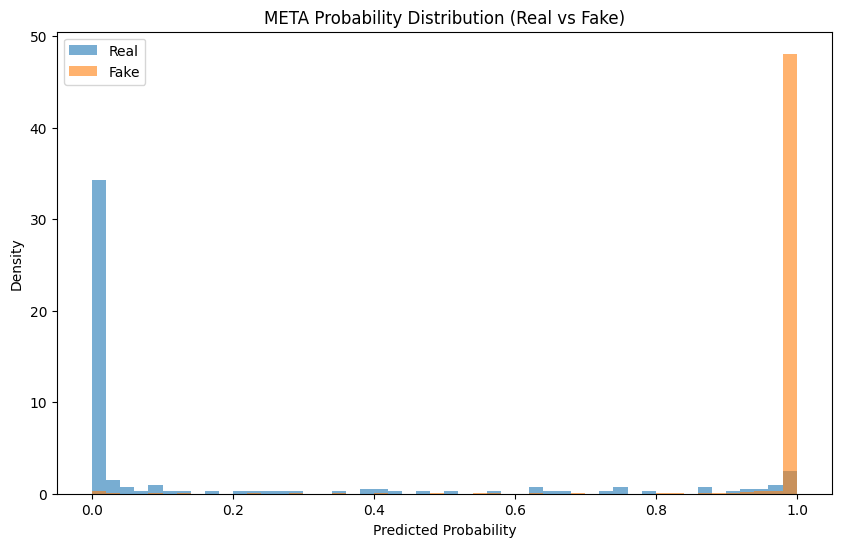

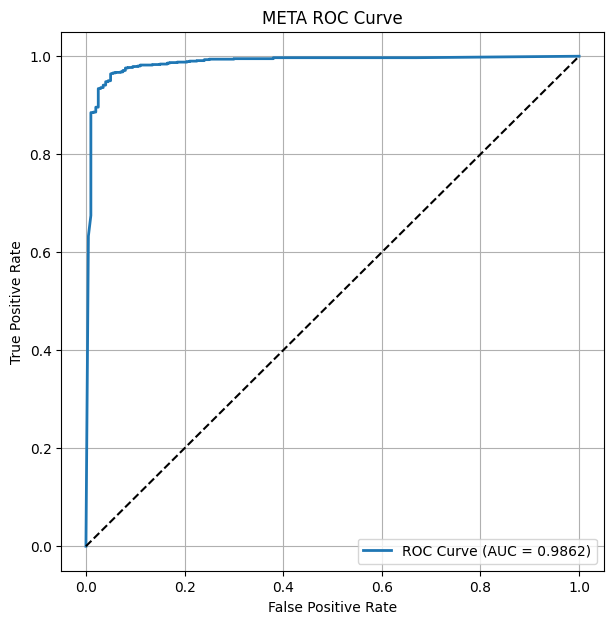

Running t-SNE (may take ~20–60 sec)...


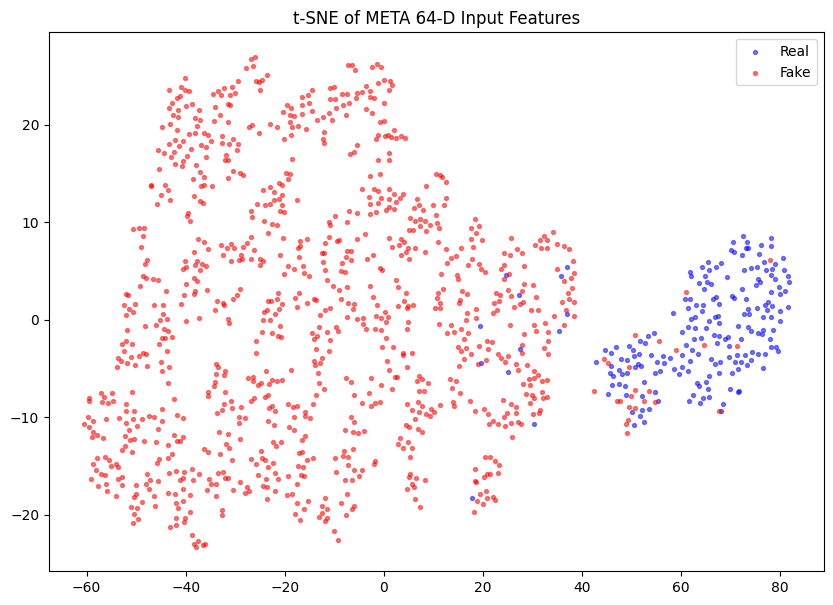

In [3]:
# ================================================
# CELL 5: Visualizations for META output (FFPP)
# ================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from pathlib import Path

# -----------------------------
# Correct FFPP paths
# -----------------------------
OUT_DIR = Path("/workspace/oof_stacking_ffpp_xgb64")
META_CSV = OUT_DIR / "test_meta_full.csv"
META_NORM = OUT_DIR / "meta_norm_full.npz"

if not META_CSV.exists():
    raise FileNotFoundError(f"{META_CSV} not found")

if not META_NORM.exists():
    raise FileNotFoundError(f"{META_NORM} not found")

# -----------------------------
# Load test results
# -----------------------------
df = pd.read_csv(META_CSV)
y_true = df["label"].astype(int).to_numpy()
p_meta = df["p_meta"].astype(float).to_numpy()

# ==================================================
# 1) HISTOGRAM of REAL vs FAKE probabilities
# ==================================================
plt.figure(figsize=(10,6))
plt.hist(p_meta[y_true==0], bins=50, alpha=0.6, label="Real", density=True)
plt.hist(p_meta[y_true==1], bins=50, alpha=0.6, label="Fake", density=True)
plt.title("META Probability Distribution (Real vs Fake)")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

# ==================================================
# 2) ROC CURVE
# ==================================================
fpr, tpr, _ = roc_curve(y_true, p_meta)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], "k--")
plt.title("META ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# ==================================================
# 3) t-SNE Visualization on 64-D encoder features
# ==================================================

norm = np.load(META_NORM, allow_pickle=True)
feat_cols = norm["feat_cols"].tolist()

# Extract 64-dim inputs to meta
X = df[feat_cols].to_numpy(dtype=np.float32)

print("Running t-SNE (may take ~20–60 sec)...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(10,7))
plt.scatter(
    X_2d[y_true==0,0], X_2d[y_true==0,1],
    s=8, c="blue", alpha=0.5, label="Real"
)
plt.scatter(
    X_2d[y_true==1,0], X_2d[y_true==1,1],
    s=8, c="red", alpha=0.5, label="Fake"
)
plt.title("t-SNE of META 64-D Input Features")
plt.legend()
plt.show()
